Now that I played with that other catalog a bit (though there are still a lot of questions) I'm going to try to do some inference on it. I have 2 Catalogs I want to work with. The full one that I got from Eli/Risa is very long, with nearly 1.5 million rows. This is much longer than the one I snagged from Buzzard 1.0. I also managed to snag a small subset of it. I'll develop and test it on the small one and I can maybe load up the large one at SLAC. 

In [225]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [226]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
#dataDir = '/nfs/slac/g/ki/ki19/des/erykoff/clusters/mocks/Buzzard/buzzard-1.1/des_y5/redmapper_v6.4.7/halos/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

In [227]:
data.columns.info()

name:
    ['HALOID', 'RA', 'DEC', 'Z', 'M200', 'R200', 'MEM_MATCH_ID', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', 'E', 'D', 'D', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', '21E', '21E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

These catalogs are nice cuz they've been paired with their corresponding masses. However, there is the trouble that there's much less error than there would be in real life. 

Rows:	76997
Log Mass V Log Richness Plot


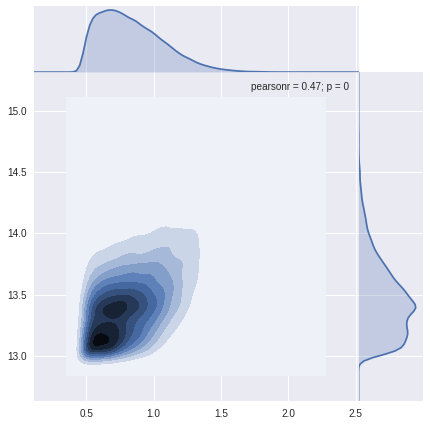

In [228]:
import numpy as np
mass = data['M200']
print 'Rows:\t%d'%mass.shape[0]
rich = data['LAMBDA_CHISQ']
mass = mass[rich>0]
rich = rich[rich>0]#slice off null values
logMass = np.log10(mass)
logRich = np.log10(rich)
print 'Log Mass V Log Richness Plot'
sns.jointplot(logRich, logMass, kind = 'kde', space = 0);

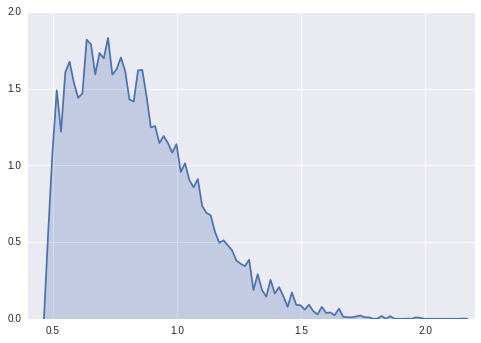

In [229]:
sns.kdeplot(logRich, shade = True, bw = .005);

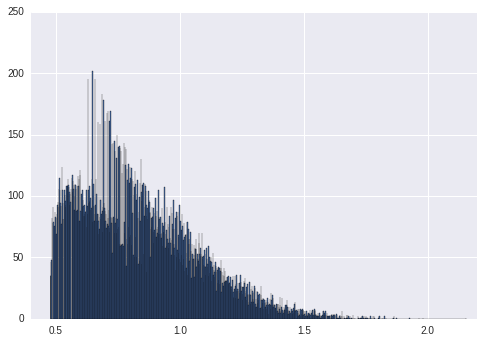

In [230]:
plt.hist(logRich, bins = 1000);

Still getting some weird behavior with these plots. For now I'm ignoring it, but will probably have to address it later.

Since I have actual masses I can before OLS regression in log space on the data. So the model in this case is:

$ \log{\lambda} = b \; \log{M} + \log{A} $

I was trying to decide how bad the OLS estimator would be in this case. Since I've assumed log-richness is log normally distributed, the errors will be Normal. I think there may be a bias in that mean, and the jointplot above shows the errors are clearly correlated. It at least serves as a baseline for our inference. 

In [231]:
from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

a: 8.261e-05	b: 3.656e-01
R^2: 0.222


Those are some astronomy regression numbers right there. I'll see if I can use Bayes magic to improve on it. 

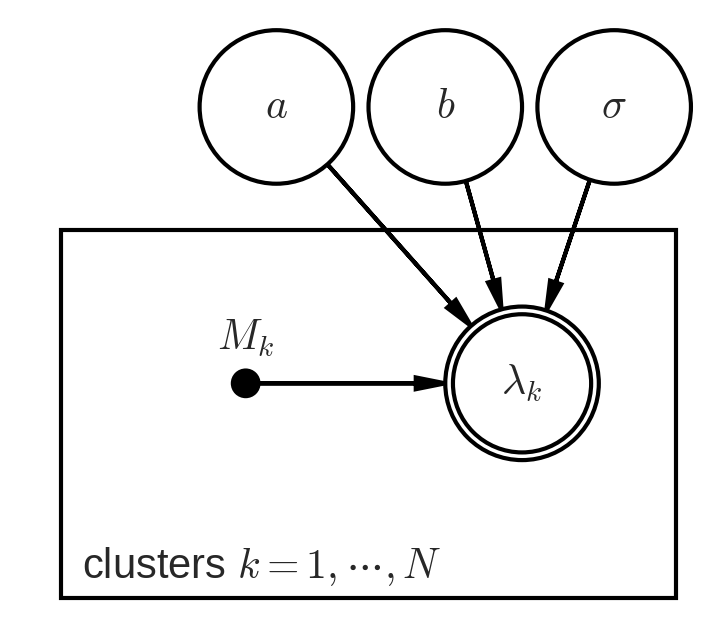

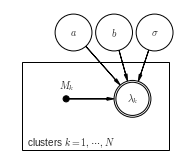

In [232]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1, fixed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM3.png", dpi = 300)
from IPython.display import Image
Image("modelPGM3.png")

This has the distribution:

$P(a,b,\sigma | \{M\}, \{\lambda\}) = \prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma) P(a,b,\sigma)\;} $

Note this is a dramatically simplified case. I hope to work up to measured rather than known masses, then removing them from the inference entirely. Here's all the liklihoods.

In [233]:
from scipy.stats import gamma
def log_prior(a,b,sigma):
    
    if any(x<0 for x in (a,sigma)):
        return -np.inf
    #if sigma<0:
    #    return - np.inf
    t = np.arctan(b)
    if t<0 or t>np.pi/2:
        return -np.inf
    
    #Hyperparameters
    lambda_a = 1
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in log a
    #p+= np.log(lambda_a)-lambda_a*np.log(a)
    p+= np.log(lambda_a)-lambda_a*a #changed a => logA TODO Change variable name?
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

from scipy.stats import lognorm
def log_liklihood(rich, M, a,b,sigma):
    p = 0

    #a => logA
    #log Normal liklihood
    #It would appear my write up is incorrect...
    #p-= np.sum(((b*np.log(M)+a-np.log(rich))**2)/(2*sigma**2)+np.log(sigma*rich))
    p+= np.sum(lognorm.logpdf(rich, sigma, loc = (b*(np.log(M))+np.log(a))))
    return p

def log_posterior(theta,rich, M):
    #print theta
    a,b,sigma = theta[:]
    p = log_prior(a,b,sigma)
    if np.isfinite(p):
        p+=log_liklihood(rich,M,a,b,sigma)
    return p

In [234]:
ndim = 3
nwalkers = 1000

a_mean, a_spread = 1, .5
b_mean, b_spread = .5, .25
sigma_mean, sigma_spread = 1, .5

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:
    #a,b,sigma,m
    #a_try = -1
    #while a_try < 0:
        #a_try = 10**(a_log_mean+np.random.randn()*a_log_spread)
    #    a_try = a_mean+np.random.randn()*a_spread
    #row[0] = a_try
    row[0] = a_mean+np.random.randn()*a_spread
    row[1] = b_mean+np.random.randn()*b_spread
    sig_try = -1
    while sig_try < 0:
        sig_try = sigma_mean+np.random.randn()*sigma_spread
    row[2] = sig_try

In [235]:
import emcee as mc
import multiprocessing
#nCores = multiprocessing.cpu_count()
nCores = 4
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, mass],threads = nCores)
nsteps, nburn = 510, 100

In [236]:
print '-*'*25
print 'Num Dim:\t%d\nNum Walkers:\t%d\nNum Steps:\t%d\nNum Burn:\t%d'%(ndim, nwalkers, nsteps, nburn)
print '-*'*25

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Num Dim:	3
Num Walkers:	1000
Num Steps:	510
Num Burn:	100
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [237]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

Ok, samplers been run. How'd we do?

In [238]:
chain = sampler.chain[:,nburn:, :].reshape((-1, ndim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain.mean(axis = 0)
labels = ['logA', 'b', 'sigma']
for label, val in zip(labels, MAP):
    print '%s:\t%.3f'%(label, val)

logA:	1.316
b:	0.380
sigma:	1.256


In [239]:
print MAP[0], 10**logA
print MAP[1], b

1.31637568886 8.26067202633e-05
0.38048744559 0.365623928309


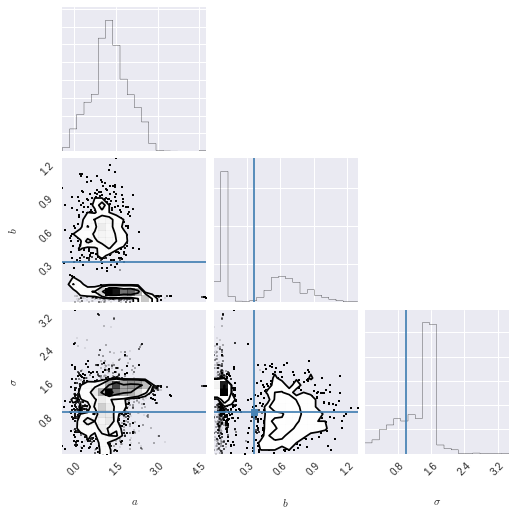

In [240]:
from corner import corner
titles = ['$a$', '$b$', '$\sigma$']
sigma_true = 1 #just a guess so this will plot
corner(chain, labels = titles , truths = [logA, b, sigma_true]);

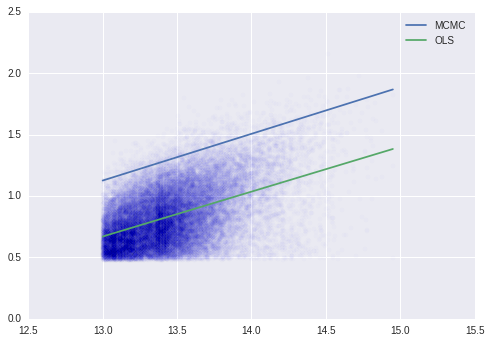

In [241]:
plt.scatter(logMass, logRich, alpha = .01)
plt.plot(logMass, MAP[1]*(logMass-13.5)+MAP[0], label = 'MCMC')
plt.plot(logMass, b*logMass+logA, label = 'OLS')
plt.legend(loc= 'best')

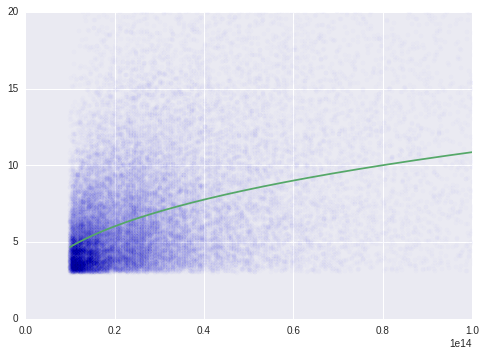

In [242]:
plt.scatter(mass, rich, alpha = .01)
plt.plot(mass, (10**MAP[0])*pow(mass-13.5, MAP[1]))
plt.plot(mass, (10**logA)*pow(mass, b))
plt.xlim([0,1e14]);
plt.ylim([0, 20]);

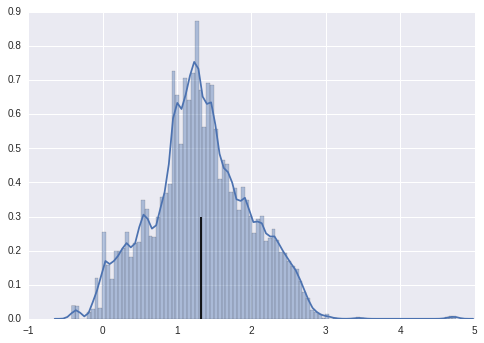

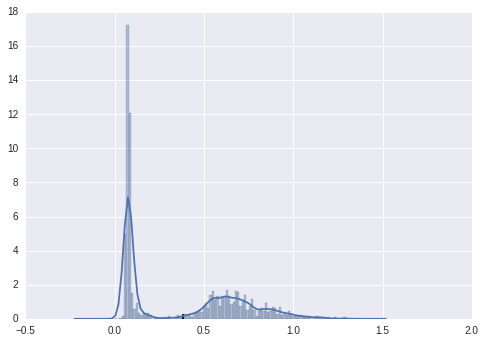

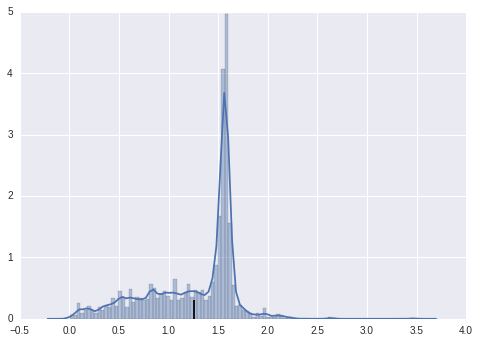

In [243]:
for i in xrange(3):
    sns.distplot(chain[:,i], bins = 100)
    plt.vlines(MAP[i], 0, .3)
    plt.show()

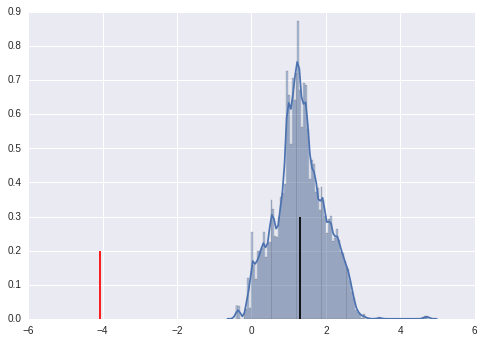

In [244]:
sns.distplot(chain[:,0], bins = 100)
plt.vlines(MAP[0], 0, .3)
plt.vlines(logA, 0 ,.2, color ='r')
plt.show()

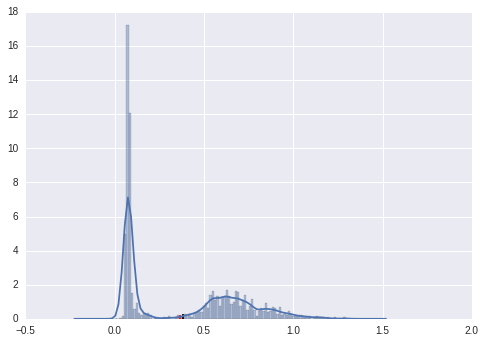

In [245]:
sns.distplot(chain[:,1], bins = 100)
plt.vlines(MAP[1], 0, .3)
plt.vlines(b, 0 ,.2, color ='r')
plt.show()

In [246]:
#np.savetxt('chain_w%d_s%d.txt'%(nwalkers, nsteps), chain)